In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import shutil
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy import sparse

import bottleneck as bn
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()

import tensorflow as tf


###############################################################################
# Data loading and preprocessing
###############################################################################

# Path to the MovieLens 20M data.  Adjust as necessary.
MOVIELENS_DIR = '/content/drive/MyDrive/Shortcuts/MovieLens/ml-20m'

# Path to the raw ratings CSV file.
RATINGS_FILE = os.path.join(MOVIELENS_DIR, 'ratings.csv')


def count_by_column(df: pd.DataFrame, col: str) -> pd.Series:
    """Return a series with counts of occurrences for each unique key in col."""
    return df.groupby(col).size()


def filter_by_min_counts(
    df: pd.DataFrame,
    min_user_count: int = 0,
    min_item_count: int = 5,
) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """
    Filter users and items from the dataframe based on minimum interaction counts.

    Parameters
    ----------
    df : pd.DataFrame
        The ratings dataframe containing columns ``userId`` and ``movieId``.
    min_user_count : int
        Users with fewer than this many interactions will be removed.
    min_item_count : int
        Items with fewer than this many users will be removed.

    Returns
    -------
    filtered_df : pd.DataFrame
        The filtered dataframe.
    user_counts : pd.Series
        Number of interactions per user in the filtered set.
    item_counts : pd.Series
        Number of interactions per item in the filtered set.
    """
    working_df = df.copy()
    # Filter out rare items first
    if min_item_count > 0:
        item_counts = count_by_column(working_df, 'movieId')
        eligible_items = item_counts[item_counts >= min_item_count].index
        working_df = working_df[working_df['movieId'].isin(eligible_items)]
    # Then filter out users with too few interactions
    if min_user_count > 0:
        user_counts = count_by_column(working_df, 'userId')
        eligible_users = user_counts[user_counts >= min_user_count].index
        working_df = working_df[working_df['userId'].isin(eligible_users)]
    # Recompute counts on the filtered set
    user_counts = count_by_column(working_df, 'userId')
    item_counts = count_by_column(working_df, 'movieId')
    return working_df, user_counts, item_counts


def split_by_prop(
    data: pd.DataFrame,
    test_fraction: float = 0.2,
    min_user_items: int = 5,
    random_seed: int = 98765,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Per-user split of data into training and test sets.

    Each user with at least ``min_user_items`` interactions contributes
    ``test_fraction`` of their items to the test set.  Users with
    fewer interactions keep all their data in the training set.

    Returns a pair of dataframes ``(train_df, test_df)``.
    """
    rng = np.random.RandomState(random_seed)
    grouped = data.groupby('userId')
    train_list: List[pd.DataFrame] = []
    test_list: List[pd.DataFrame] = []
    for i, (_, group) in enumerate(grouped):
        num_items = len(group)
        if num_items >= min_user_items:
            num_test = int(test_fraction * num_items)
            num_test = max(num_test, 1)
            test_indices = rng.choice(num_items, size=num_test, replace=False)
            mask = np.zeros(num_items, dtype=bool)
            mask[test_indices] = True
            train_list.append(group.loc[~mask])
            test_list.append(group.loc[mask])
        else:
            train_list.append(group)
        if i % 1000 == 0:
            # Print progress for large datasets
            print(f"Processed {i} users for splitting")
            sys.stdout.flush()
    train_df = pd.concat(train_list, axis=0)
    test_df = pd.concat(test_list, axis=0) if test_list else data.iloc[0:0].copy()
    return train_df, test_df


def map_ids(df: pd.DataFrame, user_map: Dict[int, int], item_map: Dict[int, int]) -> pd.DataFrame:
    """
    Map the userId and movieId columns to sequential integers based on provided maps.

    Any rows with missing values after the mapping are dropped.
    """
    uid = df['userId'].map(user_map)
    sid = df['movieId'].map(item_map)
    ratings = df['val'].astype(np.float32)
    mapped_df = pd.DataFrame({'uid': uid, 'sid': sid, 'val': ratings}).dropna()
    return mapped_df.astype({'uid': 'int64', 'sid': 'int64', 'val': 'float32'})


def build_sparse_matrix(tp: pd.DataFrame, num_items: int) -> sparse.csr_matrix:
    """
    Convert a dataframe with columns ``uid``, ``sid`` and ``val`` into a CSR matrix.

    The matrix has shape (n_users, num_items), where n_users is inferred from
    ``uid.max() + 1``.  Duplicate entries are kept only once.
    """
    tp_unique = tp.drop_duplicates(subset=['uid', 'sid'], keep='last')
    n_users = int(tp_unique['uid'].max()) + 1
    rows = tp_unique['uid'].to_numpy()
    cols = tp_unique['sid'].to_numpy()
    vals = tp_unique['val'].to_numpy(dtype=np.float32)
    return sparse.csr_matrix((vals, (rows, cols)), dtype=np.float32, shape=(n_users, num_items))


def build_train_test_mats(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    num_items: int,
) -> Tuple[sparse.csr_matrix, sparse.csr_matrix]:
    """
    Construct sparse matrices for the training and test interactions.

    Users may appear in only one of the sets; we align the user indices so
    that both matrices have the same number of rows.
    """
    train_unique = train_df.drop_duplicates(subset=['uid', 'sid'], keep='last')
    test_unique = test_df.drop_duplicates(subset=['uid', 'sid'], keep='last')
    start_idx = min(train_unique['uid'].min(), test_unique['uid'].min())
    end_idx = max(train_unique['uid'].max(), test_unique['uid'].max())
    n_users = end_idx - start_idx + 1
    # Build training matrix
    rows_tr = (train_unique['uid'] - start_idx).to_numpy()
    cols_tr = train_unique['sid'].to_numpy()
    vals_tr = train_unique['val'].to_numpy(dtype=np.float32)
    train_mat = sparse.csr_matrix((vals_tr, (rows_tr, cols_tr)), dtype=np.float32, shape=(n_users, num_items))
    # Build test matrix
    rows_te = (test_unique['uid'] - start_idx).to_numpy()
    cols_te = test_unique['sid'].to_numpy()
    vals_te = test_unique['val'].to_numpy(dtype=np.float32)
    test_mat = sparse.csr_matrix((vals_te, (rows_te, cols_te)), dtype=np.float32, shape=(n_users, num_items))
    return train_mat, test_mat


###############################################################################
# Evaluation metrics
###############################################################################

def ndcg_score_batch(scores: np.ndarray, heldout: sparse.csr_matrix, k: int = 100) -> np.ndarray:
    """
    Compute Normalised Discounted Cumulative Gain (NDCG) at K for a batch.

    Only positive entries in ``heldout`` are considered relevant; negatives
    are treated as non-relevant for the purposes of this metric.
    """
    batch_size = scores.shape[0]
    # Find top-k indices
    idx_part = bn.argpartition(-scores, k, axis=1)
    topk_part = scores[np.arange(batch_size)[:, None], idx_part[:, :k]]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_size)[:, None], idx_sort]
    discounts = 1. / np.log2(np.arange(2, k + 2))
    rel_mat = (heldout > 0).tocsr()
    rel = rel_mat[np.arange(batch_size)[:, None], idx_topk].toarray().astype(np.float32)
    dcg = (rel * discounts).sum(axis=1)
    n_pos = np.asarray(rel_mat.getnnz(axis=1)).reshape(-1)
    idcg = np.array([discounts[:min(int(n), k)].sum() for n in n_pos], dtype=np.float32)
    # Avoid division by zero
    ndcg = np.divide(dcg, idcg, out=np.zeros_like(dcg, dtype=np.float32), where=idcg > 0)
    return ndcg


def negative_hit_rate_batch(scores: np.ndarray, heldout: sparse.csr_matrix, k: int = 100) -> np.ndarray:
    """
    Compute the fraction of top-K recommendations that are explicit negatives.

    A lower value indicates that the recommender is avoiding negative items.
    """
    batch_size = scores.shape[0]
    idx_part = bn.argpartition(-scores, k, axis=1)
    topk_part = scores[np.arange(batch_size)[:, None], idx_part[:, :k]]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_size)[:, None], idx_sort]
    neg_mat = (heldout < 0).tocsr()
    neg_hits = neg_mat[np.arange(batch_size)[:, None], idx_topk].toarray().sum(axis=1)
    return (neg_hits / float(k)).astype(np.float32)


def recall_at_k_batch(scores: np.ndarray, heldout: sparse.csr_matrix, k: int = 100) -> np.ndarray:
    """
    Compute recall at K for a batch of users.
    """
    batch_size = scores.shape[0]
    idx = bn.argpartition(-scores, k, axis=1)
    pred_binary = np.zeros_like(scores, dtype=bool)
    pred_binary[np.arange(batch_size)[:, None], idx[:, :k]] = True
    true_binary = (heldout > 0).toarray()
    intersection = (np.logical_and(true_binary, pred_binary).sum(axis=1)).astype(np.float32)
    denom = np.minimum(k, true_binary.sum(axis=1))
    recall = np.divide(intersection, denom, out=np.zeros_like(intersection, dtype=np.float32), where=denom > 0)
    return recall


###############################################################################
# Autoencoder models
###############################################################################

def l2_regulariser(scale: float):
    """Return a function that computes the scaled L2 regularisation term."""
    scale = float(scale)
    def _reg(w):
        return tf.multiply(scale, tf.nn.l2_loss(w))
    return _reg


def apply_reg_to_weights(regulariser, weight_dict: List[tf.Variable]) -> tf.Tensor:
    """Sum the regulariser over all weight tensors provided."""
    terms = [regulariser(w) for w in weight_dict]
    return tf.add_n(terms) if terms else tf.constant(0.0, dtype=tf.float32)


class DenoisingAutoEncoder(object):
    """
    Multi-layer denoising autoencoder for collaborative filtering.

    The encoder and decoder architectures are determined by ``p_dims`` and
    ``q_dims``.  A minimal set of placeholders and train operations are
    constructed in ``build_graph``.  The model is designed for TF 1.x
    compatibility mode and uses negative explicit feedback weighting in
    the likelihood.
    """

    def __init__(
        self,
        p_dims: List[int],
        q_dims: List[int] = None,
        lam: float = 0.01,
        lr: float = 1e-3,
        random_seed: int = None,
    ):
        # Decoder dimensions
        self.p_dims = list(p_dims)
        # Inference (encoder) dimensions
        if q_dims is None:
            self.q_dims = self.p_dims[::-1]
        else:
            assert q_dims[0] == self.p_dims[-1], (
                "Encoder output dimension must match decoder input dimension."
            )
            assert q_dims[-1] == self.p_dims[0], (
                "Latent dimension mismatch between encoder and decoder."
            )
            self.q_dims = list(q_dims)
        # Combined layer dimensions (encoder followed by decoder sans input duplication)
        self.layer_dims = self.q_dims + self.p_dims[1:]
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed
        # Placeholders will be created in build_graph

    def init_placeholders(self):
        """Initialise placeholders used by the model."""
        self.input_ph = tf.compat.v1.placeholder(tf.float32, shape=[None, self.layer_dims[0]])
        self.keep_prob_ph = tf.compat.v1.placeholder_with_default(1.0, shape=())

    def init_weights(self):
        """Construct weight and bias variables for each layer of the autoencoder."""
        self.weights: List[tf.Variable] = []
        self.biases: List[tf.Variable] = []
        for i, (d_in, d_out) in enumerate(zip(self.layer_dims[:-1], self.layer_dims[1:])):
            w_name = f"W_{i}_{i+1}"
            b_name = f"b_{i+1}"
            w = tf.compat.v1.get_variable(
                name=w_name,
                shape=[d_in, d_out],
                initializer=tf.compat.v1.keras.initializers.glorot_uniform(seed=self.random_seed),
            )
            b = tf.compat.v1.get_variable(
                name=b_name,
                shape=[d_out],
                initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.001, seed=self.random_seed),
            )
            self.weights.append(w)
            self.biases.append(b)
            # Log histograms for TensorBoard
            tf.compat.v1.summary.histogram(w_name, w)
            tf.compat.v1.summary.histogram(b_name, b)

    def modified_likelihood(self, logits: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Compute the modified negative log-likelihood for explicit +/- feedback.

        This method replaces the multinomial likelihood used in implicit
        collaborative filtering with a weighted likelihood that penalises
        explicit negative interactions.  ``logits`` is the output of
        the decoder before the softmax.

        Returns a tuple (neg_ll, probability) where ``neg_ll`` is the
        negative log-likelihood and ``probability`` is the softmax output.
        """
        prob = tf.nn.softmax(logits, axis=1)
        is_negative = tf.less(self.input_ph, 0.0)
        # For negative entries use 1 - p_ij, else use p_ij
        adjusted_prob = tf.where(is_negative, 1.0 - prob, prob)
        # Avoid taking log of zero
        adjusted_prob = tf.clip_by_value(adjusted_prob, 1e-10, 1.0)
        log_prob = tf.math.log(adjusted_prob)
        # Weight negative feedback differently
        lambda_neg = tf.constant(0.1, tf.float32)
        weights = tf.where(is_negative, lambda_neg, 1.0)
        neg_ll = -tf.reduce_mean(tf.reduce_sum(weights * log_prob * tf.abs(self.input_ph), axis=1))
        return neg_ll, prob

    def forward_pass(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor]:
        """Perform a forward pass through the autoencoder and return logits."""
        h = tf.nn.l2_normalize(self.input_ph, axis=1)
        h = tf.compat.v1.nn.dropout(h, keep_prob=self.keep_prob_ph)
        for idx, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            if idx != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.compat.v1.train.Saver(), h

    def build_graph(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor, tf.Tensor, tf.Operation, tf.Tensor]:
        """
        Build the TensorFlow graph for training the autoencoder.

        Returns the saver, logits, loss, train operation and merged summary.
        """
        self.init_placeholders()
        self.init_weights()
        saver, logits = self.forward_pass()
        neg_ll, _ = self.modified_likelihood(logits)
        # Regularisation
        reg = l2_regulariser(self.lam)
        reg_term = apply_reg_to_weights(reg, self.weights)
        loss = neg_ll + 2.0 * reg_term
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(loss)
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('loss', loss)
        merged = tf.compat.v1.summary.merge_all()
        return saver, logits, loss, train_op, merged


class VariationalAutoEncoder(DenoisingAutoEncoder):
    """
    Variational autoencoder for collaborative filtering with explicit feedback.

    Extends the denoising autoencoder by introducing a variational latent
    space.  The architecture is defined by ``p_dims`` (decoder dims) and
    ``q_dims`` (encoder dims).
    """

    def init_placeholders(self):
        super().init_placeholders()
        self.is_training_ph = tf.compat.v1.placeholder_with_default(0.0, shape=())
        self.anneal_ph = tf.compat.v1.placeholder_with_default(1.0, shape=())

    def _init_variational_weights(self):
        """Initialise separate weight matrices for the variational encoder and decoder."""
        # Encoder weights and biases
        self.encoder_weights: List[tf.Variable] = []
        self.encoder_biases: List[tf.Variable] = []
        for i, (din, dout) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            # For the last layer, double the output size to produce mean and log variance
            if i == len(self.q_dims[:-1]) - 1:
                dout *= 2
            w_name = f"W_enc_{i}_{i+1}"
            b_name = f"b_enc_{i+1}"
            w = tf.compat.v1.get_variable(
                name=w_name,
                shape=[din, dout],
                initializer=tf.compat.v1.keras.initializers.glorot_uniform(seed=self.random_seed),
            )
            b = tf.compat.v1.get_variable(
                name=b_name,
                shape=[dout],
                initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.001, seed=self.random_seed),
            )
            self.encoder_weights.append(w)
            self.encoder_biases.append(b)
            tf.compat.v1.summary.histogram(w_name, w)
            tf.compat.v1.summary.histogram(b_name, b)
        # Decoder weights and biases
        self.decoder_weights: List[tf.Variable] = []
        self.decoder_biases: List[tf.Variable] = []
        for i, (din, dout) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            w_name = f"W_dec_{i}_{i+1}"
            b_name = f"b_dec_{i+1}"
            w = tf.compat.v1.get_variable(
                name=w_name,
                shape=[din, dout],
                initializer=tf.compat.v1.keras.initializers.glorot_uniform(seed=self.random_seed),
            )
            b = tf.compat.v1.get_variable(
                name=b_name,
                shape=[dout],
                initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.001, seed=self.random_seed),
            )
            self.decoder_weights.append(w)
            self.decoder_biases.append(b)
            tf.compat.v1.summary.histogram(w_name, w)
            tf.compat.v1.summary.histogram(b_name, b)

    def q_network(self) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Build the inference network (encoder) returning mean, std and KL divergence.
        """
        h = tf.nn.l2_normalize(self.input_ph, axis=1)
        h = tf.compat.v1.nn.dropout(h, keep_prob=self.keep_prob_ph)
        mu, std, kl = None, None, None
        for i, (w, b) in enumerate(zip(self.encoder_weights, self.encoder_biases)):
            h = tf.matmul(h, w) + b
            if i != len(self.encoder_weights) - 1:
                h = tf.nn.tanh(h)
            else:
                latent_dim = self.q_dims[-1]
                mu = h[:, :latent_dim]
                logvar = h[:, latent_dim:]
                std = tf.exp(0.5 * logvar)
                # KL divergence for Gaussian latent variables
                kl = tf.reduce_mean(
                    tf.reduce_sum(
                        0.5 * (-logvar + tf.exp(logvar) + tf.square(mu) - 1.0), axis=1
                    )
                )
        return mu, std, kl

    def p_network(self, z: tf.Tensor) -> tf.Tensor:
        """
        Build the generative network (decoder) given latent samples z.
        """
        h = z
        for i, (w, b) in enumerate(zip(self.decoder_weights, self.decoder_biases)):
            h = tf.matmul(h, w) + b
            if i != len(self.decoder_weights) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor, tf.Tensor]:
        """
        Forward pass through the variational autoencoder.
        Returns saver, logits and KL divergence.
        """
        mu_q, std_q, kl = self.q_network()
        eps = tf.compat.v1.random_normal(tf.shape(std_q))
        sampled_z = mu_q + self.is_training_ph * eps * std_q
        logits = self.p_network(sampled_z)
        return tf.compat.v1.train.Saver(), logits, kl

    def build_graph(self) -> Tuple[tf.compat.v1.train.Saver, tf.Tensor, tf.Tensor, tf.Operation, tf.Tensor]:
        """
        Build the TensorFlow graph for training the variational autoencoder.
        Returns the saver, logits, objective, train op and merged summary.
        """
        self.init_placeholders()
        self._init_variational_weights()
        saver, logits, kl = self.forward_pass()
        neg_ll, _ = self.modified_likelihood(logits)
        reg = l2_regulariser(self.lam)
        reg_term = apply_reg_to_weights(reg, self.encoder_weights + self.decoder_weights)
        neg_elbo = neg_ll + self.anneal_ph * kl + 2.0 * reg_term
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(neg_elbo)
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('kl_divergence', kl)
        tf.compat.v1.summary.scalar('neg_ELBO_train', neg_elbo)
        merged = tf.compat.v1.summary.merge_all()
        return saver, logits, neg_elbo, train_op, merged


In [3]:
# Load raw ratings and convert to +/- labels around 3.5
ratings = pd.read_csv(RATINGS_FILE, header=0)
ratings['val'] = np.where(ratings['rating'] >= 3.5, 1.0, -1.0).astype(np.float32)
# Filter rare items
ratings, user_counts, item_counts = filter_by_min_counts(ratings, min_user_count=0, min_item_count=5)
# Compute sparsity
sparsity = 1.0 * ratings.shape[0] / (user_counts.shape[0] * item_counts.shape[0])
print(
    f"After filtering: {ratings.shape[0]} events, {user_counts.shape[0]} users, "
    f"{item_counts.shape[0]} items (sparsity: {sparsity * 100:.3f}%)"
)
# Select eligible users for splitting (with at least 5 items)
eligible_users = user_counts[user_counts >= 5].index.to_numpy()
rng = np.random.RandomState(98765)
eligible_users = eligible_users[rng.permutation(len(eligible_users))]
n_users = len(eligible_users)
n_heldout_users = min(10000, n_users // 3)
n_heldout_users = max(1, n_heldout_users)
train_users = eligible_users[: (n_users - 2 * n_heldout_users)]
val_users = eligible_users[(n_users - 2 * n_heldout_users) : (n_users - n_heldout_users)]
test_users = eligible_users[(n_users - n_heldout_users) :]
train_df = ratings.loc[ratings['userId'].isin(train_users)].copy()
# Map item IDs for training only
unique_items = pd.unique(train_df['movieId'])
item_to_idx = {sid: i for i, sid in enumerate(unique_items)}
# Map users for all splits
all_users = np.concatenate([train_users, val_users, test_users])
user_to_idx = {uid: i for i, uid in enumerate(all_users)}
# Create output directory
output_dir = os.path.join(MOVIELENS_DIR, 'processed')
os.makedirs(output_dir, exist_ok=True)
# Save unique item IDs
with open(os.path.join(output_dir, 'unique_items.txt'), 'w') as f:
    for sid in unique_items:
        f.write(f"{sid}\n")
# Split validation and test sets by proportion
val_raw = ratings.loc[ratings['userId'].isin(val_users)]
val_raw = val_raw[val_raw['movieId'].isin(unique_items)]
val_train, val_test = split_by_prop(val_raw)
test_raw = ratings.loc[ratings['userId'].isin(test_users)]
test_raw = test_raw[test_raw['movieId'].isin(unique_items)]
test_train, test_test = split_by_prop(test_raw)
# Numerise
train_num = map_ids(train_df, user_to_idx, item_to_idx)
train_num.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
val_train_num = map_ids(val_train, user_to_idx, item_to_idx)
val_train_num.to_csv(os.path.join(output_dir, 'validation_train.csv'), index=False)
val_test_num = map_ids(val_test, user_to_idx, item_to_idx)
val_test_num.to_csv(os.path.join(output_dir, 'validation_test.csv'), index=False)
test_train_num = map_ids(test_train, user_to_idx, item_to_idx)
test_train_num.to_csv(os.path.join(output_dir, 'test_train.csv'), index=False)
test_test_num = map_ids(test_test, user_to_idx, item_to_idx)
test_test_num.to_csv(os.path.join(output_dir, 'test_test.csv'), index=False)
# Build sparse matrices for training
num_items = len(unique_items)
train_mat = build_sparse_matrix(train_num, num_items)
val_train_mat, val_test_mat = build_train_test_mats(val_train_num, val_test_num, num_items)
# Define training hyperparameters
num_epochs = 200
batch_size = 500
batch_size_val = 2000
total_anneal_steps = 200_000
anneal_cap = 0.2
# Model architecture: n_items -> 600 -> 200 -> 600 -> n_items
latent_dims = [200, 600, num_items]
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
vae = VariationalAutoEncoder(latent_dims, lam=0.0, random_seed=98765)
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()
# Set up logging directories
base_log_dir = os.path.join(MOVIELENS_DIR, 'logs')
base_ckpt_dir = os.path.join(MOVIELENS_DIR, 'checkpoints')
arch_tag = "I-" + "-".join([str(d) for d in vae.layer_dims[1:-1]]) + "-I"
log_dir = os.path.join(base_log_dir, f"ml-20m/VAE_{total_anneal_steps/1000:.0f}K_cap{anneal_cap:.1E}", arch_tag)
ckpt_dir = os.path.join(base_ckpt_dir, f"ml-20m/VAE_{total_anneal_steps/1000:.0f}K_cap{anneal_cap:.1E}", arch_tag)
# Clean and create directories
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
print("Log directory:", log_dir)
print("Checkpoint directory:", ckpt_dir)
summary_writer = tf.compat.v1.summary.FileWriter(log_dir, graph=tf.compat.v1.get_default_graph())
# Prepare index lists
N = train_mat.shape[0]
train_indices = np.arange(N, dtype=np.int64)
N_val = val_train_mat.shape[0]
val_indices = np.arange(N_val, dtype=np.int64)
ndcg_history: List[float] = []
update_counter = 0.0
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    best_ndcg = -np.inf
    for epoch in range(num_epochs):
        np.random.shuffle(train_indices)
        # Training loop
        for bnum, start in enumerate(range(0, N, batch_size)):
            end = min(start + batch_size, N)
            batch_indices = train_indices[start:end]
            X = train_mat[batch_indices]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype(np.float32, copy=False)
            # Annealing schedule
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, update_counter / float(total_anneal_steps))
            else:
                anneal = anneal_cap
            feed_dict = {
                vae.input_ph: X,
                vae.keep_prob_ph: 0.5,
                vae.anneal_ph: anneal,
                vae.is_training_ph: 1.0,
            }
            sess.run(train_op_var, feed_dict=feed_dict)
            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, int(epoch * np.ceil(N / batch_size) + bnum))
                summary_writer.flush()
            update_counter += 1.0
        # Validation evaluation
        ndcg_dist = []
        neg_rate_dist = []
        for bnum, start in enumerate(range(0, N_val, batch_size_val)):
            end = min(start + batch_size_val, N_val)
            batch_indices = val_indices[start:end]
            X_val = val_train_mat[batch_indices]
            if sparse.isspmatrix(X_val):
                X_val = X_val.toarray()
            X_val = X_val.astype(np.float32, copy=False)
            preds = sess.run(logits_var, feed_dict={vae.input_ph: X_val})
            # Mask out seen interactions from ranking
            preds[X_val.nonzero()] = -np.inf
            heldout = val_test_mat[batch_indices]
            ndcg_dist.append(ndcg_score_batch(preds, heldout, k=100))
            neg_rate_dist.append(negative_hit_rate_batch(preds, heldout, k=100))
        ndcg_dist = np.concatenate(ndcg_dist).astype(np.float32)
        neg_rate_dist = np.concatenate(neg_rate_dist).astype(np.float32)
        # Compute scalar ndcg ignoring NaNs
        finite_mask = np.isfinite(ndcg_dist)
        ndcg_clean = ndcg_dist[finite_mask]
        ndcg_scalar = float(ndcg_clean.mean()) if ndcg_clean.size > 0 else 0.0
        ndcg_history.append(ndcg_scalar)
        # Log validation summaries
        ndcg_scalar_ph = tf.compat.v1.placeholder(tf.float32, shape=())
        ndcg_dist_ph = tf.compat.v1.placeholder(tf.float32, shape=[None])
        neg_rate_ph = tf.compat.v1.placeholder(tf.float32, shape=())
        ndcg_summary = tf.compat.v1.summary.scalar('ndcg_at_k_validation', ndcg_scalar_ph)
        ndcg_hist_summary = tf.compat.v1.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_ph)
        neg_rate_summary = tf.compat.v1.summary.scalar('neg_hit_rate_at_k_validation', neg_rate_ph)
        merged_valid = tf.compat.v1.summary.merge([ndcg_summary, ndcg_hist_summary, neg_rate_summary])
        merged_val = sess.run(merged_valid, feed_dict={
            ndcg_scalar_ph: np.float32(ndcg_scalar),
            ndcg_dist_ph: ndcg_dist,
            neg_rate_ph: np.float32(float(neg_rate_dist.mean()))
        })
        summary_writer.add_summary(merged_val, epoch)
        summary_writer.flush()
        # Save best model
        if ndcg_scalar > best_ndcg:
            saver.save(sess, os.path.join(ckpt_dir, 'model'))
            best_ndcg = ndcg_scalar
            print(f"Epoch {epoch:03d}: NDCG@100={ndcg_scalar:.5f} (best, saved)")
        else:
            print(f"Epoch {epoch:03d}: NDCG@100={ndcg_scalar:.5f} (best={best_ndcg:.5f})")

After filtering: 19984024 events, 138493 users, 18345 items (sparsity: 0.787%)
Processed 0 users for splitting
Processed 1000 users for splitting
Processed 2000 users for splitting
Processed 3000 users for splitting
Processed 4000 users for splitting
Processed 5000 users for splitting
Processed 6000 users for splitting
Processed 7000 users for splitting
Processed 8000 users for splitting
Processed 9000 users for splitting
Processed 0 users for splitting
Processed 1000 users for splitting
Processed 2000 users for splitting
Processed 3000 users for splitting
Processed 4000 users for splitting
Processed 5000 users for splitting
Processed 6000 users for splitting
Processed 7000 users for splitting
Processed 8000 users for splitting
Processed 9000 users for splitting


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Log directory: /content/drive/MyDrive/Shortcuts/MovieLens/ml-20m/logs/ml-20m/VAE_200K_cap2.0E-01/I-600-200-600-I
Checkpoint directory: /content/drive/MyDrive/Shortcuts/MovieLens/ml-20m/checkpoints/ml-20m/VAE_200K_cap2.0E-01/I-600-200-600-I
Epoch 000: NDCG@100=0.27707 (best, saved)
Epoch 001: NDCG@100=0.31371 (best, saved)
Epoch 002: NDCG@100=0.34077 (best, saved)
Epoch 003: NDCG@100=0.35432 (best, saved)
Epoch 004: NDCG@100=0.36333 (best, saved)
Epoch 005: NDCG@100=0.37222 (best, saved)
Epoch 006: NDCG@100=0.37621 (best, saved)
Epoch 007: NDCG@100=0.37973 (best, saved)
Epoch 008: NDCG@100=0.38264 (best, saved)
Epoch 009: NDCG@100=0.38537 (best, saved)
Epoch 010: NDCG@100=0.38503 (best=0.38537)
Epoch 011: NDCG@100=0.38829 (best, saved)
Epoch 012: NDCG@100=0.38805 (best=0.38829)
Epoch 013: NDCG@100=0.38881 (best, saved)
Epoch 014: NDCG@100=0.39108 (best, saved)
Epoch 015: NDCG@100=0.39071 (best=0.39108)
Epoch 016: NDCG@100=0.39206 (best, saved)
Epoch 017: NDCG@100=0.39424 (best, saved)
E

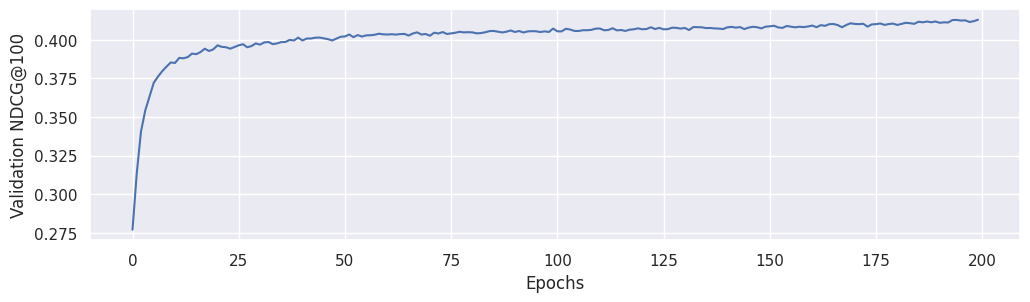

In [4]:
# Plot validation curve
plt.figure(figsize=(12, 3))
plt.plot(ndcg_history)
plt.ylabel('Validation NDCG@100')
plt.xlabel('Epochs')
plt.show()

In [ ]:
# =======================================
# Load the test data and compute metrics
# =======================================

# Load numerized test data (created in the preprocessing step)
test_train_num = pd.read_csv(os.path.join(output_dir, 'test_train.csv'))
test_test_num  = pd.read_csv(os.path.join(output_dir, 'test_test.csv'))

# Build sparse matrices for test interactions
test_tr_mat, test_te_mat = build_train_test_mats(test_train_num, test_test_num, num_items)

# Convert test heldout to positive and negative binary matrices
def to_pos_binary(mat_csr):
    """Return CSR with 1s where mat > 0, else 0."""
    m = mat_csr.tocsr(copy=True)
    m.data = (m.data > 0).astype(np.float32)
    m.eliminate_zeros()
    return m

def to_neg_binary(mat_csr):
    """Return CSR with 1s where mat < 0, else 0."""
    m = mat_csr.tocsr(copy=True)
    m.data = (m.data < 0).astype(np.float32)
    m.eliminate_zeros()
    return m

test_te_pos = to_pos_binary(test_te_mat)  # for NDCG/Recall
test_te_neg = to_neg_binary(test_te_mat)  # for NegHitRate

# Build graph for evaluation and restore the best model
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

# Use the same architecture and random seed as during training
vae_eval = VariationalAutoEncoder(latent_dims, lam=0.0, random_seed=98765)
saver_eval, logits_eval, _, _, _ = vae_eval.build_graph()

# Find the latest checkpoint in the previously defined ckpt_dir
ckpt_path = tf.train.latest_checkpoint(ckpt_dir)
if ckpt_path is None:
    # Fallback: search manually for .index files if tf.latest_checkpoint returns None
    index_files = sorted(
        glob.glob(os.path.join(ckpt_dir, '**', '*.index'), recursive=True),
        key=os.path.getmtime
    )
    if not index_files:
        raise FileNotFoundError(f'No TensorFlow checkpoints found under {ckpt_dir}')
    ckpt_path = index_files[-1].replace('.index', '')

print('Restoring checkpoint:', ckpt_path)

# Evaluation batch parameters
N_test = test_tr_mat.shape[0]
idxlist_test = np.arange(N_test, dtype=np.int64)
batch_size_test = 2000

# Lists to collect per-user metrics
ndcg100_list, recall20_list, recall50_list, neghit100_list = [], [], [], []

with tf.compat.v1.Session() as sess:
    saver_eval.restore(sess, ckpt_path)

    # Loop over the test users in batches
    for st_idx in range(0, N_test, batch_size_test):
        end_idx = min(st_idx + batch_size_test, N_test)
        batch_idx = idxlist_test[st_idx:end_idx]

        X = test_tr_mat[batch_idx]
        X_dense = X.toarray().astype(np.float32, copy=False)

        feed_dict = {
            vae_eval.input_ph: X_dense,
            vae_eval.keep_prob_ph: 1.0,     # no dropout at test time
            vae_eval.is_training_ph: 0.0    # use mean of q(z|x)
        }

        # Compute the reconstructed logits
        pred = sess.run(logits_eval, feed_dict=feed_dict)

        # Mask out all seen interactions (both positive and negative) from ranking
        pred[X_dense.nonzero()] = -np.inf

        # True positives and negatives for this batch
        y_pos = test_te_pos[batch_idx]
        y_neg = test_te_neg[batch_idx]

        # Compute metrics for the batch and append
        ndcg100_list.append(ndcg_score_batch(pred, y_pos, k=100))
        recall20_list.append(recall_at_k_batch(pred, y_pos, k=20))
        recall50_list.append(recall_at_k_batch(pred, y_pos, k=50))
        neghit100_list.append(negative_hit_rate_batch(pred, y_neg, k=100))

# Concatenate results and compute means and standard errors
ndcg100  = np.concatenate(ndcg100_list).astype(np.float32)
r20      = np.concatenate(recall20_list).astype(np.float32)
r50      = np.concatenate(recall50_list).astype(np.float32)
negh100  = np.concatenate(neghit100_list).astype(np.float32)

def mean_se(x: np.ndarray) -> Tuple[float, float]:
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 0.0
    return float(x.mean()), float(x.std(ddof=0) / np.sqrt(x.size))

m_ndcg, se_ndcg   = mean_se(ndcg100)
m_r20,  se_r20    = mean_se(r20)
m_r50,  se_r50    = mean_se(r50)
m_negh, se_negh   = mean_se(negh100)

print(f'Test NDCG@100 = {m_ndcg:.5f} ({se_ndcg:.5f})')
print(f'Test Recall@20 = {m_r20:.5f} ({se_r20:.5f})')
print(f'Test Recall@50 = {m_r50:.5f} ({se_r50:.5f})')

In [16]:
import numpy as np
import bottleneck as bn
from scipy import sparse
import glob
import tensorflow as tf

# ========================================================
# Additional ranking metrics
# ========================================================

def precision_at_k_batch(X_pred, heldout_batch, k=100):
    """
    Precision@k: fraction of top-k recommendations that are relevant.
    """
    batch_users = X_pred.shape[0]
    idx = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, None], idx] = True
    X_true_binary = (heldout_batch > 0).toarray()
    # number of relevant items retrieved divided by k
    precision = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32) / k
    return precision

def map_at_k_batch(X_pred, heldout_batch, k=100):
    """
    Mean Average Precision@k (MAP@k).
    For each user, compute AP@k and return an array of shape (batch_users,).
    """
    batch_users = X_pred.shape[0]
    # get top-k indices sorted by prediction score
    idx_part = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    topk_part = X_pred[np.arange(batch_users)[:, None], idx_part]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_users)[:, None], idx_sort]  # sorted top-k indices

    X_true = (heldout_batch > 0).toarray().astype(np.float32)
    ap = np.zeros(batch_users, dtype=np.float32)
    for u in range(batch_users):
        hits = 0.0
        sum_precisions = 0.0
        for rank, item_idx in enumerate(idx_topk[u], start=1):
            if X_true[u, item_idx] > 0:
                hits += 1
                sum_precisions += hits / rank
        n_relevant = float(min(X_true[u].sum(), k))
        ap[u] = sum_precisions / n_relevant if n_relevant > 0 else 0.0
    return ap

def mrr_at_k_batch(X_pred, heldout_batch, k=100):
    """
    Mean Reciprocal Rank@k (MRR@k).
    """
    batch_users = X_pred.shape[0]
    idx_part = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    topk_part = X_pred[np.arange(batch_users)[:, None], idx_part]
    idx_sort = np.argsort(-topk_part, axis=1)
    idx_topk = idx_part[np.arange(batch_users)[:, None], idx_sort]

    X_true = (heldout_batch > 0).toarray().astype(np.bool_)
    mrr = np.zeros(batch_users, dtype=np.float32)
    for u in range(batch_users):
        ranks = np.where(X_true[u, idx_topk[u]])[0]
        if ranks.size > 0:
            mrr[u] = 1.0 / (ranks[0] + 1)  # +1 because ranks are 0-based
        else:
            mrr[u] = 0.0
    return mrr

def hit_rate_at_k_batch(X_pred, heldout_batch, k=100):
    """
    Hit Rate@k: 1 if at least one relevant item is in the top-k, else 0.
    """
    batch_users = X_pred.shape[0]
    idx = bn.argpartition(-X_pred, k, axis=1)[:, :k]
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, None], idx] = True
    X_true_binary = (heldout_batch > 0).toarray()
    hits = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1) > 0).astype(np.float32)
    return hits

# ========================================================
# Load the test data (assumes you've already saved them)
# ========================================================
test_train_num = pd.read_csv(os.path.join(output_dir, 'test_train.csv'))
test_test_num  = pd.read_csv(os.path.join(output_dir, 'test_test.csv'))
test_tr_mat, test_te_mat = build_train_test_mats(test_train_num, test_test_num, num_items)

# Convert test held-out to positive and negative CSR matrices
test_te_pos = to_pos_binary(test_te_mat)
test_te_neg = to_neg_binary(test_te_mat)

# ========================================================
# Restore the best model and evaluate all metrics
# ========================================================
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

vae_eval = VariationalAutoEncoder(latent_dims, lam=0.0, random_seed=98765)
saver_eval, logits_eval, _, _, _ = vae_eval.build_graph()

# Load the latest checkpoint from the directory
ckpt_path = tf.train.latest_checkpoint(ckpt_dir)
if ckpt_path is None:
    index_files = sorted(glob.glob(os.path.join(ckpt_dir, '**', '*.index'), recursive=True),
                         key=os.path.getmtime)
    if not index_files:
        raise FileNotFoundError(f'No checkpoints found in {ckpt_dir}')
    ckpt_path = index_files[-1].replace('.index', '')

print(f'Restoring checkpoint: {ckpt_path}')

# Evaluation batch parameters
N_test = test_tr_mat.shape[0]
idxlist_test = np.arange(N_test, dtype=np.int64)
batch_size_test = 2000

# Lists to collect per-user metrics
ndcg100_list   = []
recall20_list  = []
recall50_list  = []
neghit100_list = []
precision20_list  = []
precision50_list  = []
precision100_list = []
map100_list    = []
mrr100_list    = []
hit20_list     = []
hit50_list     = []
hit100_list    = []

with tf.compat.v1.Session() as sess:
    saver_eval.restore(sess, ckpt_path)

    for st_idx in range(0, N_test, batch_size_test):
        end_idx = min(st_idx + batch_size_test, N_test)
        batch_idx = idxlist_test[st_idx:end_idx]

        X = test_tr_mat[batch_idx]
        X_dense = X.toarray().astype(np.float32, copy=False)

        feed_dict = {
            vae_eval.input_ph: X_dense,
            vae_eval.keep_prob_ph: 1.0,
            vae_eval.is_training_ph: 0.0
        }

        # Compute the reconstructed logits
        preds = sess.run(logits_eval, feed_dict=feed_dict)

        # Mask out seen interactions from ranking (both positive and negative)
        preds[X_dense.nonzero()] = -np.inf

        heldout_pos = test_te_pos[batch_idx]
        heldout_neg = test_te_neg[batch_idx]

        # Standard metrics
        ndcg100_list.append(ndcg_score_batch(preds, heldout_pos, k=100))
        recall20_list.append(recall_at_k_batch(preds, heldout_pos, k=20))
        recall50_list.append(recall_at_k_batch(preds, heldout_pos, k=50))
        neghit100_list.append(negative_hit_rate_batch(preds, heldout_neg, k=100))

        # Additional metrics
        precision20_list.append(precision_at_k_batch(preds, heldout_pos, k=20))
        precision50_list.append(precision_at_k_batch(preds, heldout_pos, k=50))
        precision100_list.append(precision_at_k_batch(preds, heldout_pos, k=100))

        map100_list.append(map_at_k_batch(preds, heldout_pos, k=100))
        mrr100_list.append(mrr_at_k_batch(preds, heldout_pos, k=100))

        hit20_list.append(hit_rate_at_k_batch(preds, heldout_pos, k=20))
        hit50_list.append(hit_rate_at_k_batch(preds, heldout_pos, k=50))
        hit100_list.append(hit_rate_at_k_batch(preds, heldout_pos, k=100))

# Concatenate results
ndcg100  = np.concatenate(ndcg100_list).astype(np.float32)
r20      = np.concatenate(recall20_list).astype(np.float32)
r50      = np.concatenate(recall50_list).astype(np.float32)
negh100  = np.concatenate(neghit100_list).astype(np.float32)
prec20   = np.concatenate(precision20_list).astype(np.float32)
prec50   = np.concatenate(precision50_list).astype(np.float32)
prec100  = np.concatenate(precision100_list).astype(np.float32)
map100   = np.concatenate(map100_list).astype(np.float32)
mrr100   = np.concatenate(mrr100_list).astype(np.float32)
hit20    = np.concatenate(hit20_list).astype(np.float32)
hit50    = np.concatenate(hit50_list).astype(np.float32)
hit100   = np.concatenate(hit100_list).astype(np.float32)

# Helper to compute mean and standard error
def mean_se(x):
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 0.0
    return float(x.mean()), float(x.std(ddof=0) / np.sqrt(x.size))

# Report metrics with standard errors
metrics = {
    'NDCG@100'      : ndcg100,
    'Recall@20'     : r20,
    'Recall@50'     : r50,
    'Precision@20'  : prec20,
    'Precision@50'  : prec50,
    'Precision@100' : prec100,
    'MAP@100'       : map100,
    'MRR@100'       : mrr100,
    'HitRate@20'    : hit20,
    'HitRate@50'    : hit50,
    'HitRate@100'   : hit100,
}

for name, values in metrics.items():
    mean, se = mean_se(values)
    print(f'{name:14s} = {mean:.5f} (±{se:.5f})')


Restoring checkpoint: /content/drive/MyDrive/Shortcuts/MovieLens/ml-20m/checkpoints/ml-20m/VAE_200K_cap2.0E-01/I-600-200-600-I/model
NDCG@100       = 0.41150 (±0.00229)
Recall@20      = 0.37886 (±0.00274)
Recall@50      = 0.48402 (±0.00287)
Precision@20   = 0.19624 (±0.00185)
Precision@50   = 0.12790 (±0.00132)
Precision@100  = 0.08636 (±0.00097)
MAP@100        = 0.20656 (±0.00182)
MRR@100        = 0.53227 (±0.00408)
HitRate@20     = 0.84740 (±0.00360)
HitRate@50     = 0.90180 (±0.00298)
HitRate@100    = 0.93090 (±0.00254)


# Data Analysis

User‑ and item‑activity distributions. Plot histograms of how many items each user interacts with and how many users each item attracts.

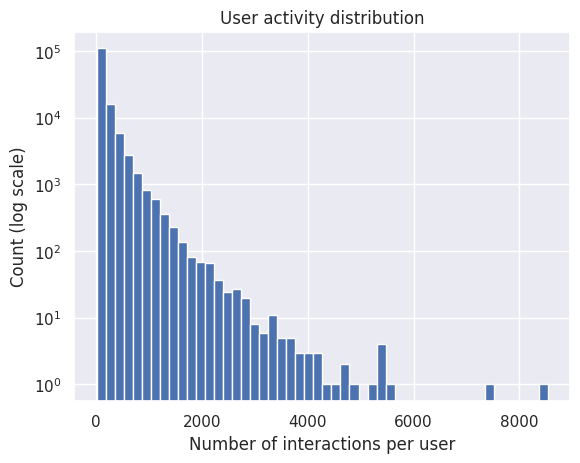

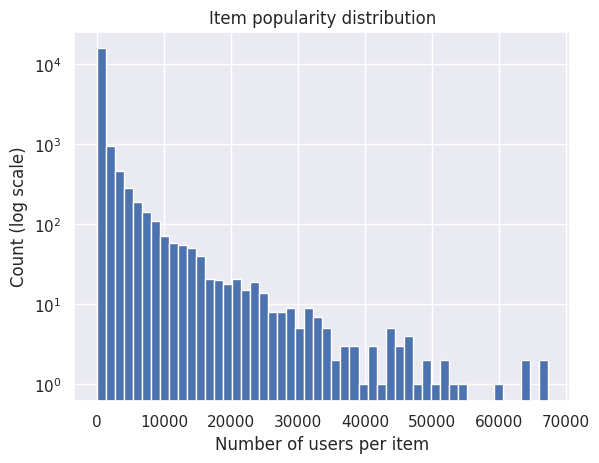

In [17]:
# Distribution of interactions per user
plt.figure()
plt.hist(user_counts.values, bins=50, log=True)
plt.xlabel('Number of interactions per user')
plt.ylabel('Count (log scale)')
plt.title('User activity distribution')
plt.show()

# Distribution of interactions per item
plt.figure()
plt.hist(item_counts.values, bins=50, log=True)
plt.xlabel('Number of users per item')
plt.ylabel('Count (log scale)')
plt.title('Item popularity distribution')
plt.show()

Latent space visualisation. After training, we projected user or item embeddings into 2D using t‑SNE or UMAP to see if similar users/items cluster together. For example, to visualise user latent vectors:

In [ ]:
from sklearn.manifold import TSNE

# Get the mean of the variational posterior for each user
with tf.compat.v1.Session() as sess:
    saver.restore(sess, ckpt_path)
    z_mu = []
    for st_idx in range(0, N, batch_size):
        batch = train_mat[st_idx:st_idx + batch_size].toarray()
        feed = {vae_eval.input_ph: batch, vae_eval.keep_prob_ph: 1.0, vae_eval.is_training_ph: 0.0}
        mu, _, _ = sess.run(vae_eval.q_network(), feed_dict=feed)
        z_mu.append(mu)
    z_mu = np.vstack(z_mu)

tsne = TSNE(n_components=2, perplexity=30)
z_emb = tsne.fit_transform(z_mu)

plt.figure()
plt.scatter(z_emb[:, 0], z_emb[:, 1], alpha=0.5, s=5)
plt.title('t-SNE projection of user embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
